In [1]:
# all imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading in the data

adult = pd.read_csv("/kaggle/input/nhanes3-processed/adult_data.csv")
adult.drop(columns=["Unnamed: 0"], inplace=True)

lab = pd.read_csv("/kaggle/input/nhanes3-processed/lab_data.csv")
lab.drop(columns=["Unnamed: 0"], inplace=True)

exam = pd.read_csv("/kaggle/input/nhanes3-processed/exam_data.csv")
exam.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
# observing the starting shape of our datasets

print("Adult:", adult.shape)
print("Lab:", lab.shape)
print("Exam:", exam.shape)

Adult: (20050, 1238)
Lab: (29314, 356)
Exam: (31311, 2368)


In [4]:
# setting up lists of relevant columns from each dataset

adult_cols = ['SEQN', 'DMARETHN', 'HSSEX', 'HSAGEIR', 'HFA8R', 'HFF18', 'HAC4A', 'HAD1', 'HAD5R', 'HAR1', 'HAT1S', 'HAT1MET', 'HAT2', 'HAT2MET', 'HAT3S', 'HAT4', 'HAT4MET', 'HAT5S', 'HAT6', 'HAT6MET', 'HAT7S', 'HAT8', 'HAT8MET', 'HAT9S', 'HAT10', 'HAT10MET', 'HAT11S', 'HAT12', 'HAT12MET', 'HAT13S', 'HAT14', 'HAT14MET', 'HAT15S', 'HAT16', 'HAT16MET', 'HAT17S', 'HAT18', 'HAT19MET', 'HAT20S', 'HAT21CD', 'HAT21MET', 'HAT22S', 'HAT23CD', 'HAT23MET', 'HAT24S', 'HAT25CD', 'HAT25MET', 'HAT26S']
lab_cols = ['SEQN', 'PHPFAST', 'SGPSI', 'G1PSI', 'G1PCODE', 'G1PTIM2', 'G2PSI', 'I1P', 'I1PSI', 'I2P', 'I2PSI']
exam_cols = ['SEQN','HXPSESSR', 'SPPTIME', 'PEP3B1', 'PEP3LARM', 'PEP3RARM', 'PEP3BFL1', 'PEP3BFL2', 'PEP3BFL3', 'PEP3BFL4', 'PEP3BFL5', 'PEP3BFR1', 'PEP3BFR2', 'PEP3BFR3', 'PEP3BFR4', 'PEP3BFR5', 'PEP3B2', 'PEP3LLEG', 'PEP3RLEG', 'PEP3B2TR', 'PEP3B2TL', 'BMPBMI', 'BMPWT', 'BMPHT', 'BMPSITHT', 'BMPSRHIS', 'BMPLEG', 'BMPKNEE', 'PEPPREG', 'PEPPACE', 'MYPC17', 'MYPC2']

In [5]:
# filtering out irrelevant columns

adult = adult[adult_cols]
lab = lab[lab_cols]
exam = exam[exam_cols]

In [6]:
# observing new shape of the datasets

print("Adult:", adult.shape)
print("Lab:", lab.shape)
print("Exam:", exam.shape)

Adult: (20050, 48)
Lab: (29314, 11)
Exam: (31311, 32)


# Preprocessing Adult Data

In [7]:
# mapping ethnicity encodings to actual values
# one-hot encoding ethnicities

ethnicity_map = {
    1: 'Non-Hispanic white',
    2: 'Non-Hispanic black',
    3: 'Mexican-American',
    4: 'Other'
}

adult['DMARETHN'] = adult['DMARETHN'].map(ethnicity_map)
adult = pd.get_dummies(adult, columns=['DMARETHN'], prefix='ethnicity')

In [8]:
# correcting the encoding for Sex

adult['HSSEX'] = adult['HSSEX'] - 1

# male 0
# female 1

In [9]:
def probabilistic_imputation(df, column, values_to_replace) -> pd.DataFrame:
    """
    Inputs:
    1. df - data frame
    2. column - column with missing values to impute
    3. values_to_replace - tracking which values must be imputed
    
    Outputs:
    1. df - data frame
    
    Logic:
    This function uses a probabilistic imputing procedure to deal with the 
    irrelevant encodings that are usually present in NHANES data. This method
    should ensure that the general proportions are retained.
    """
    
    probabilities = df[~df[column].isin(values_to_replace)][column].value_counts(normalize=True)
    impute_list = []
    
    for value, prob in probabilities.items():
        impute_list.extend([value] * int(prob * 10000))
        
    missing_indices = df[df[column].isin(values_to_replace)].index
    for idx in missing_indices:
        df.at[idx, column] = np.random.choice(impute_list)
    
    return df

In [10]:
# imputing values in education variable

# old approach
# mean_value = int(adult[(adult['HFA8R'] != 88) & (adult['HFA8R'] != 99)]['HFA8R'].mean())
# adult['HFA8R'] = adult['HFA8R'].replace({99: 0, 88: mean_value})
# adult['HFA8R'] = np.where(adult['HFA8R'] <= 12, 0, 1)

# <= 12 years of studying --> 0
# > 12 years of studying --> 1

adult = probabilistic_imputation(adult, 'HFA8R', [88, 99])
adult['HFA8R'] = np.where(adult['HFA8R'] <= 12, 0, 1)

In [11]:
# imputing values in the income variable

# old approach
# mapping = {0: 0, 1: 0, 2: 1, 8: 8, 9: 9}
# adult['HFF18'] = adult['HFF18'].map(mapping)

# 0, 1, 8, 9 --> 0 (< $20,000)
# 2 --> 1 (>= $20,000)

adult = probabilistic_imputation(adult, 'HFF18', [8, 9])
mapping = {0: 0, 1: 0, 2: 1}
adult['HFF18'] = adult['HFF18'].map(mapping)

In [12]:
# imputing values in family history of diabetes

# old approach
# mapping = {1: 1, 2: 0, 8: 0, 9: 0}
# adult['HAC4A'] = adult['HAC4A'].map(mapping).astype(int)

# 0 - no family history
# 1 - yes family history

adult = probabilistic_imputation(adult, 'HAC4A', [8, 9])
mapping = {1: 1, 2: 0}
adult['HAC4A'] = adult['HAC4A'].map(mapping).astype(int)

In [13]:
# imputing values in diabetes variable

# old approach
# mapping = {1: 1, 2: 0, 8: 0, 9: 0}
# adult['HAD1'] = adult['HAD1'].map(mapping).astype(int)

# 1 - told that they have diabetes by a doctor
# 0 - not told

adult = probabilistic_imputation(adult, 'HAD1', [8, 9])
mapping = {1: 1, 2: 0}
adult['HAD1'] = adult['HAD1'].map(mapping).astype(int)

In [14]:
mapping = {888: 0, 999: 0}

adult['HAD5R'] = adult['HAD5R'].replace(mapping)

In [15]:
# drop all subjects who were diagnosed with diabetes (according to research paper)

adult = adult[adult['HAD1'] != 1]

In [16]:
# dropping columns which are not required
adult.drop(columns = ['HAD1', 'HAD5R'], inplace=True)

In [17]:
# imputing values in the smoking variable

# old approach
# mapping = {1: 1, 2: 0, 8: 0}
# adult['HAR1'] = adult['HAR1'].map(mapping).astype(int)

# 1 - Ever Smokers
# 0 - Never Smokers

adult = probabilistic_imputation(adult, 'HAR1', [8])
mapping = {1: 1, 2: 0}
adult['HAR1'] = adult['HAR1'].map(mapping).astype(int)

In [18]:
# obtaining physical activity

how_often_columns = ['HAT1S', 'HAT3S', 'HAT5S', 'HAT7S', 'HAT9S', 'HAT11S', 'HAT13S', 'HAT15S', 'HAT17S']
did_activity_columns = ['HAT2', 'HAT4', 'HAT6', 'HAT8', 'HAT10', 'HAT12', 'HAT14', 'HAT16']

how_often_mapping = {8888: 0, 9999: 0}

for column in how_often_columns:
    adult[column] = adult[column].replace(how_often_mapping)

for column in did_activity_columns:
    adult[column] = adult[column].where(adult[column] == 1, 0)

In [19]:
# dropping columns which are not required

columns_to_drop = ['HAT18', 'HAT19MET', 'HAT20S', 'HAT21CD', 'HAT21MET', 'HAT22S', 'HAT23CD', 'HAT23MET', 'HAT24S', 'HAT25CD', 'HAT25MET', 'HAT26S']
adult.drop(columns=columns_to_drop, inplace=True)

In [20]:
# ensuring that there are no unrealistic values present in the data
for column in how_often_columns:
    adult[column] = adult[column].mask(adult[column] > 100, 0)

In [21]:
# processing physical activity columns

activity_groups = [
    ['HAT2', 'HAT2MET', 'HAT3S'],
    ['HAT4', 'HAT4MET', 'HAT5S'],
    ['HAT6', 'HAT6MET', 'HAT7S'],
    ['HAT8', 'HAT8MET', 'HAT9S'],
    ['HAT10', 'HAT10MET', 'HAT11S'],
    ['HAT12', 'HAT12MET', 'HAT13S'],
    ['HAT14', 'HAT14MET', 'HAT15S'],
    ['HAT16', 'HAT16MET', 'HAT17S'],
    ['HAT1S', 'HAT1MET']
]

adult['physical_activity'] = 0

for group in activity_groups:
    if len(group) == 3:
        adult['physical_activity'] += adult[group[0]] * adult[group[1]] * adult[group[2]]
    elif len(group) == 2:
        adult['physical_activity'] += adult[group[0]] * adult[group[1]]

In [22]:
# dropping all individual activity columns now that they are not required

columns_to_drop = np.concatenate(activity_groups).tolist()
adult.drop(columns = columns_to_drop, inplace=True)

In [23]:
# setting dtype of ethnicity columns (which were one-hot encoded)

ethnicity_columns = ['ethnicity_Mexican-American', 'ethnicity_Non-Hispanic black', 'ethnicity_Non-Hispanic white', 'ethnicity_Other']
adult[ethnicity_columns] = adult[ethnicity_columns].astype(int)

In [24]:
# renaming columns for easy access

column_mapping = {
    'SEQN': 'SEQN',
    'HSSEX': 'Sex',
    'HSAGEIR': 'Age',
    'HFA8R': 'Grade_Greater_12',
    'HFF18': 'Income_Greater_20',
    'HAC4A': 'Parental_Diabetes',
    'HAR1': '100_Cigarettes',
    'ethnicity_Mexican-American': 'Mexican',
    'ethnicity_Non-Hispanic black': 'Black',
    'ethnicity_Non-Hispanic white': 'White',
    'ethnicity_Other': 'Other'
}

adult.rename(columns=column_mapping, inplace=True)

In [25]:
# dropping column due to redundant information

adult.drop(columns='Other', inplace=True)

In [26]:
adult.head()

,SEQN,Sex,Age,Grade_Greater_12,Income_Greater_20,Parental_Diabetes,100_Cigarettes,Mexican,Black,White,physical_activity
0,3,0,21,0,0,1,0,1,0,0,NaN
1,4,1,32,1,1,1,0,1,0,0,NaN
2,9,1,48,1,1,1,1,0,0,1,NaN
3,10,0,35,1,1,0,0,0,0,1,NaN
5,19,0,44,1,0,0,1,0,1,0,NaN


In [27]:
# saving the processed adult data for future use
adult.to_csv('processed_adult.csv', index=False)

# Preprocessing Lab Data

In [28]:
lab.head()

,SEQN,PHPFAST,SGPSI,G1PSI,G1PCODE,G1PTIM2,G2PSI,I1P,I1PSI,I2P,I2PSI
0,3,6.52,5.50,5.884,NaN,NaN,NaN,9.32,55.92,NaN,NaN
1,4,6.12,4.88,4.935,NaN,NaN,NaN,5.97,35.82,NaN,NaN
2,7,88888.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,13.73,6.05,6.178,NaN,122.0,7.882,10.80,64.80,NaN,NaN
4,10,15.45,4.72,4.746,NaN,NaN,NaN,5.77,34.62,NaN,NaN


In [29]:
# Replace 88888 with NaN in the 'PHPFAST' column
lab['PHPFAST'] = lab['PHPFAST'].replace(88888.0, np.nan)

In [30]:
# do the same for other
lab['SGPSI'] = lab['SGPSI'].replace(88888.0, np.nan)
lab['G1PSI'] = lab['G1PSI'].replace(888888.0, np.nan)
lab['G1PSI'] = lab['G1PSI'].replace(888888.0, np.nan)

In [31]:
# filter out subjects for whom valid OGTT data could not be taken

lab = lab[lab['G1PCODE'].isna()]
lab.reset_index(drop=True, inplace=True)

In [32]:
# using mean imputation to fill in missing values of time between 2 draws of blood 

mean_value = lab.loc[lab['G1PTIM2'] != 888, 'G1PTIM2'].mean()
lab['G1PTIM2'] = lab['G1PTIM2'].replace(888, mean_value)

In [33]:
# excluding subjects for whom the second draw was not within 120 +- 15 mins

lab = lab[(lab['G1PTIM2'] >= 105) & (lab['G1PTIM2'] <= 135)]

In [34]:
# replacing values for which we do not have any collected data

lab.loc[lab['G2PSI'] == 888888.0, 'G2PSI'] = np.nan
lab.loc[lab['I1P'] == 888888.0, 'I1P'] = np.nan
lab.loc[lab['I1PSI'] == 8888888.0, 'I1PSI'] = np.nan
lab.loc[lab['I2P'] == 888888.0, 'I2P'] = np.nan
lab.loc[lab['I2PSI'] == 8888888.0, 'I2PSI'] = np.nan

In [35]:
# calculating the mean for Plasma Glucose and Serum Insulin for potential use in future
# dropping unrequired columns

lab['Plasma_Glucose_Avg'] = lab[['G1PSI', 'G2PSI']].mean(axis=1)
lab['Serum_Insulin_uu_ml_Avg'] = lab[['I1P', 'I2P']].mean(axis=1)
lab['Serum_Insulin_pmol_l_Avg'] = lab[['I1PSI', 'I2PSI']].mean(axis=1)

lab.drop(columns=['SGPSI', 'G1PCODE', 'G1PTIM2'], inplace=True)

In [36]:
# renaming columns for easy access

lab = lab.rename(columns={
    'SEQN': 'SEQN',
    'PHPFAST': 'Fast_Time',
    'Plasma_Glucose_Avg': 'Plasma_Glucose_Avg_mmol_l', 
    'Serum_Insulin_uu_ml_Avg': 'Serum_Insulin_uu_ml_Avg',
    'Serum_Insulin_pmol_l_Avg': 'Serum_Insulin_pmol_l_Avg',
    'G1PSI': 'First_Plasma_Glucose',
    'G2PSI': 'Second_Plasma_Glucose',
    'I1P': 'First_Serum_Insulin_uu_ml',
    'I2P': 'Second_Serum_Insulin_uu_ml',
    'I1PSI': 'First_Serum_Insulin_pmol_l',
    'I2PSI': 'Second_Serum_Insulin_pmol_l'
})

In [37]:
lab.head()

,SEQN,Fast_Time,First_Plasma_Glucose,Second_Plasma_Glucose,First_Serum_Insulin_uu_ml,First_Serum_Insulin_pmol_l,Second_Serum_Insulin_uu_ml,Second_Serum_Insulin_pmol_l,Plasma_Glucose_Avg_mmol_l,Serum_Insulin_uu_ml_Avg,Serum_Insulin_pmol_l_Avg
3,9,13.73,6.178,7.882,10.80,64.80,NaN,NaN,7.0300,10.80,64.80
17,34,12.28,5.490,4.940,9.82,58.92,NaN,NaN,5.2150,9.82,58.92
33,51,13.27,4.896,8.493,40.00,240.00,NaN,NaN,6.6945,40.00,240.00
34,52,0.00,5.346,5.729,8.92,53.52,NaN,NaN,5.5375,8.92,53.52
37,55,6.25,6.212,5.279,12.31,73.86,NaN,NaN,5.7455,12.31,73.86


In [38]:
# saving data as a csv for future use

lab.to_csv('processed_lab.csv', index=False)

# Preprocessing Exam Data

In [39]:
exam.head()

,SEQN,HXPSESSR,SPPTIME,PEP3B1,PEP3LARM,PEP3RARM,PEP3BFL1,PEP3BFL2,PEP3BFL3,PEP3BFL4,...,BMPWT,BMPHT,BMPSITHT,BMPSRHIS,BMPLEG,BMPKNEE,PEPPREG,PEPPACE,MYPC17,MYPC2
0,3,NaN,09:25,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,81.60,178.8,93.1,NaN,44.4,NaN,2.0,2.0,NaN,NaN
1,4,NaN,17:43,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,61.65,162.2,86.1,NaN,38.4,NaN,2.0,2.0,NaN,NaN
2,7,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,13.05,97.3,51.3,NaN,21.0,NaN,NaN,NaN,NaN,NaN
3,9,NaN,11:06,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,68.05,156.9,84.9,NaN,35.4,NaN,2.0,2.0,NaN,NaN
4,10,NaN,15:03,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,92.50,177.4,93.7,NaN,43.0,NaN,2.0,2.0,NaN,NaN


In [40]:
# replacing NHANES encoding with actual values for session time

mapping = {1: 'Morning', 2: 'Afternoon', 3: 'Evening', 8: pd.NA}

exam['HXPSESSR'] = exam['HXPSESSR'].replace(mapping)

In [41]:
# using time values to impute missing values in the session column
# useful to screen out subjects for improper fasting as per their session
# (according to the research paper)

exam['SPPTIME'] = exam['SPPTIME'].replace("88888", pd.NA)

exam['Hour'] = exam['SPPTIME'].str.slice(0, 2)
exam['Hour'] = exam['Hour'].fillna(-1)
exam['Hour'] = exam['Hour'].astype(float)

morning_condition = (exam['Hour'] >= 6) & (exam['Hour'].astype(float) < 12)
afternoon_condition = (exam['Hour'] >= 12) & (exam['Hour'].astype(float) < 18)
evening_condition = (exam['Hour'] >= 18) | ((exam['Hour'] >= 0) & (exam['Hour'] < 6))

exam.loc[morning_condition, 'HXPSESSR'] = 'Morning'
exam.loc[afternoon_condition, 'HXPSESSR'] = 'Afternoon'
exam.loc[evening_condition, 'HXPSESSR'] = 'Evening'

exam['HXPSESSR'] = exam['HXPSESSR'].replace(-1, pd.NA)

exam.drop(columns=['SPPTIME', 'Hour'], inplace=True)

In [42]:
# filtering out subjects who are amputees or have casts (as per the research paper)

exam = exam[(exam['PEP3B1'] != 2) & (exam['PEP3B2'] != 2)]


columns_to_drop = ['PEP3B1', 'PEP3LARM', 'PEP3RARM', 'PEP3BFL1', 'PEP3BFL2', 'PEP3BFL3', 'PEP3BFL4', 'PEP3BFL5', 
                   'PEP3BFR1', 'PEP3BFR2', 'PEP3BFR3', 'PEP3BFR4', 'PEP3BFR5', 'PEP3B2', 'PEP3LLEG', 'PEP3RLEG', 
                   'PEP3B2TR', 'PEP3B2TL']

exam.drop(columns=columns_to_drop, inplace=True)

In [43]:
# replacing encodings for which we do not have any useful data

exam.loc[exam['BMPBMI'] == 8888.0, 'BMPBMI'] = np.nan
exam.loc[exam['BMPWT'] == 888888.0, 'BMPWT'] = np.nan
exam.loc[exam['BMPHT'] == 88888.0, 'BMPHT'] = np.nan
exam.loc[exam['BMPSITHT'] == 88888.0, 'BMPSITHT'] = np.nan

In [44]:
# calculating the leg length using Standing Height - Sitting Height 
# (according to the research paper)

exam['Leg_Length_cm'] = exam['BMPHT'] - exam['BMPSITHT']

In [45]:
# dropping unrequired columns

exam.drop(columns=['BMPLEG', 'BMPKNEE', 'BMPSRHIS'], inplace=True)

In [46]:
# replacing encodings in the menarche columns for which there is no useful data

exam['MYPC2'] = exam['MYPC2'].replace([88, 99], np.nan)

exam = exam[exam['MYPC2'] != 0]

In [47]:
# excluding subjects with pacemakers or who are pregnant 
# (as per the research paper)

mask = (exam['PEPPREG'] == 1) | (exam['PEPPACE'] == 1) | (exam['MYPC17'] == 1)
exam = exam[~mask]

exam.drop(columns=['PEPPREG', 'PEPPACE', 'MYPC17'], inplace=True)

In [48]:
# renaming columns for easy access

exam.rename(columns={
    'SEQN': 'SEQN',
    'HXPSESSR': 'Session_Time',
    'BMPBMI': 'BMI',
    'BMPWT': 'Weight_kg',
    'BMPHT': 'Standing_Height_cm',
    'BMPSITHT': 'Sitting_Height_cm',
    'MYPC2': 'Menarche',
    'Leg_Length_cm': 'Leg_Length_cm'
}, inplace=True)

In [49]:
exam.head()

,SEQN,Session_Time,BMI,Weight_kg,Standing_Height_cm,Sitting_Height_cm,Menarche,Leg_Length_cm
0,3,Morning,25.5,81.60,178.8,93.1,NaN,85.7
1,4,Afternoon,23.4,61.65,162.2,86.1,NaN,76.1
2,7,NaN,13.8,13.05,97.3,51.3,NaN,46.0
3,9,Morning,27.6,68.05,156.9,84.9,NaN,72.0
4,10,Afternoon,29.4,92.50,177.4,93.7,NaN,83.7


In [50]:
# saving data as a csv for future use

exam.to_csv('processed_exam.csv', index=False)

# Merging all 3 DataFrames and Cleaning

In [51]:
# merging all 3 data frames

merged_df = adult.merge(lab, on='SEQN', how='inner')
merged_df = merged_df.merge(exam, on='SEQN', how='inner')

In [52]:
merged_df

,SEQN,Sex,Age,Grade_Greater_12,Income_Greater_20,Parental_Diabetes,100_Cigarettes,Mexican,Black,White,...,Plasma_Glucose_Avg_mmol_l,Serum_Insulin_uu_ml_Avg,Serum_Insulin_pmol_l_Avg,Session_Time,BMI,Weight_kg,Standing_Height_cm,Sitting_Height_cm,Menarche,Leg_Length_cm
0,9,1,48,1,1,1,1,0,0,1,...,7.0300,10.800,64.80,Morning,27.6,68.05,156.9,84.9,NaN,72.0
1,34,1,42,0,1,0,1,0,1,0,...,5.2150,9.820,58.92,Morning,22.6,57.20,159.0,81.9,NaN,77.1
2,51,0,44,0,0,0,1,1,0,0,...,6.6945,40.000,240.00,Morning,44.4,144.50,180.5,95.1,NaN,85.4
3,52,0,50,0,1,1,0,1,0,0,...,5.5375,8.920,53.52,Morning,25.1,79.60,178.2,95.4,NaN,82.8
4,55,0,48,0,0,0,1,1,0,0,...,5.7455,12.310,73.86,Afternoon,37.5,111.65,172.6,91.8,NaN,80.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,53559,1,73,1,1,0,1,0,0,1,...,5.5845,36.070,216.42,Morning,24.2,55.60,151.7,78.9,NaN,72.8
5175,53569,1,42,0,1,1,0,0,0,0,...,6.4280,37.005,222.03,Afternoon,24.2,74.35,175.3,87.3,NaN,88.0
5176,53582,0,63,0,0,1,1,1,0,0,...,5.9005,31.935,191.61,NaN,21.0,58.65,167.0,85.3,NaN,81.7
5177,53583,1,51,0,1,1,1,0,0,1,...,6.1340,37.300,223.80,Afternoon,22.2,53.85,155.9,84.5,NaN,71.4


In [53]:
merged_df.columns

Index(['SEQN', 'Sex', 'Age', 'Grade_Greater_12', 'Income_Greater_20',
       'Parental_Diabetes', '100_Cigarettes', 'Mexican', 'Black', 'White',
       'physical_activity', 'Fast_Time', 'First_Plasma_Glucose',
       'Second_Plasma_Glucose', 'First_Serum_Insulin_uu_ml',
       'First_Serum_Insulin_pmol_l', 'Second_Serum_Insulin_uu_ml',
       'Second_Serum_Insulin_pmol_l', 'Plasma_Glucose_Avg_mmol_l',
       'Serum_Insulin_uu_ml_Avg', 'Serum_Insulin_pmol_l_Avg', 'Session_Time',
       'BMI', 'Weight_kg', 'Standing_Height_cm', 'Sitting_Height_cm',
       'Menarche', 'Leg_Length_cm'],
      dtype='object')

In [54]:
merged_df.drop(columns=['physical_activity', 'Menarche'], inplace=True)

In [55]:
# excluding subjects that did not fast properly

morning_condition = (merged_df['Session_Time'] == 'Morning') & (merged_df['Fast_Time'] >= 12)
afternoon_evening_condition = ((merged_df['Session_Time'] == 'Afternoon') | (merged_df['Session_Time'] == 'Evening')) & (merged_df['Fast_Time'] >= 6)

proper_fasting_condition = morning_condition | afternoon_evening_condition

merged_df = merged_df[proper_fasting_condition]

In [56]:
# dropping unrequired columns

merged_df = merged_df.drop(columns=['Fast_Time', 'Sitting_Height_cm', 'Weight_kg', 'Second_Serum_Insulin_pmol_l', 'Second_Serum_Insulin_uu_ml'])

In [57]:
# dropping na values - used since only 4 missing values were present
merged_df.dropna(subset=['BMI'], inplace=True)

In [58]:
# observing number of missing values in each column
merged_df.isna().sum().sort_values(ascending=False)

Leg_Length_cm                 41
First_Serum_Insulin_pmol_l    35
First_Serum_Insulin_uu_ml     35
Serum_Insulin_pmol_l_Avg      24
Serum_Insulin_uu_ml_Avg       24
Second_Plasma_Glucose          0
Standing_Height_cm             0
BMI                            0
Session_Time                   0
Plasma_Glucose_Avg_mmol_l      0
SEQN                           0
Sex                            0
White                          0
Black                          0
Mexican                        0
100_Cigarettes                 0
Parental_Diabetes              0
Income_Greater_20              0
Grade_Greater_12               0
Age                            0
First_Plasma_Glucose           0
dtype: int64

In [59]:
# observing the shape of the current data
merged_df.shape

(4321, 21)

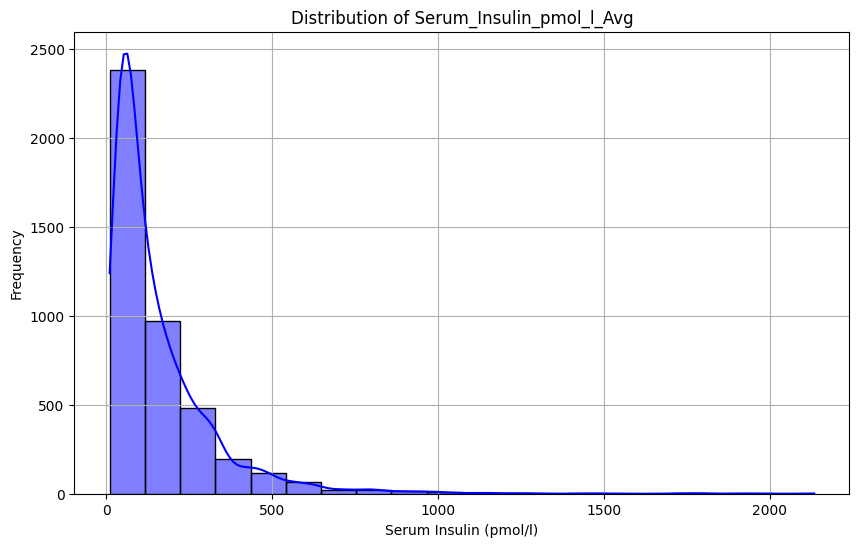

In [60]:
# observing the distribution to ascertain the most appropriate imputation method

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Serum_Insulin_pmol_l_Avg'], bins=20, kde=True, color='blue')
plt.title('Distribution of Serum_Insulin_pmol_l_Avg')
plt.xlabel('Serum Insulin (pmol/l)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

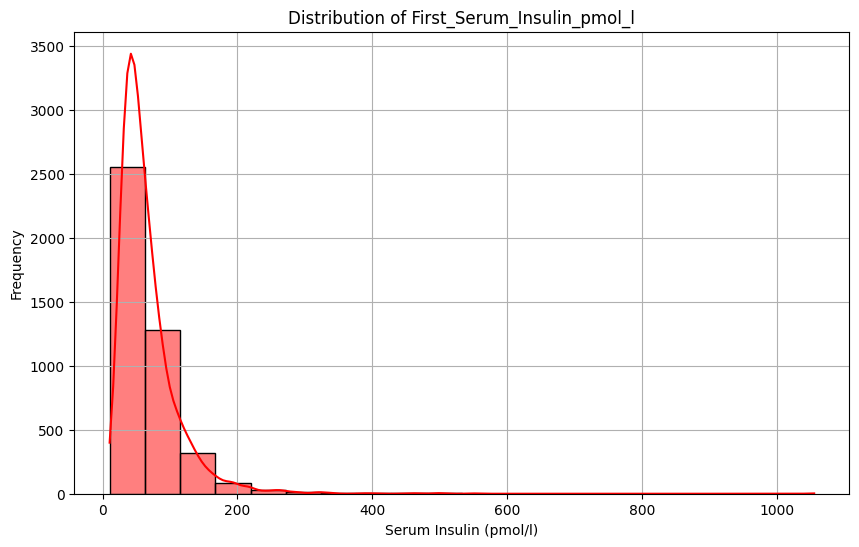

In [61]:
# observing the distribution to ascertain the most appropriate imputation method

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['First_Serum_Insulin_pmol_l'], bins=20, kde=True, color='red')
plt.title('Distribution of First_Serum_Insulin_pmol_l')
plt.xlabel('Serum Insulin (pmol/l)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

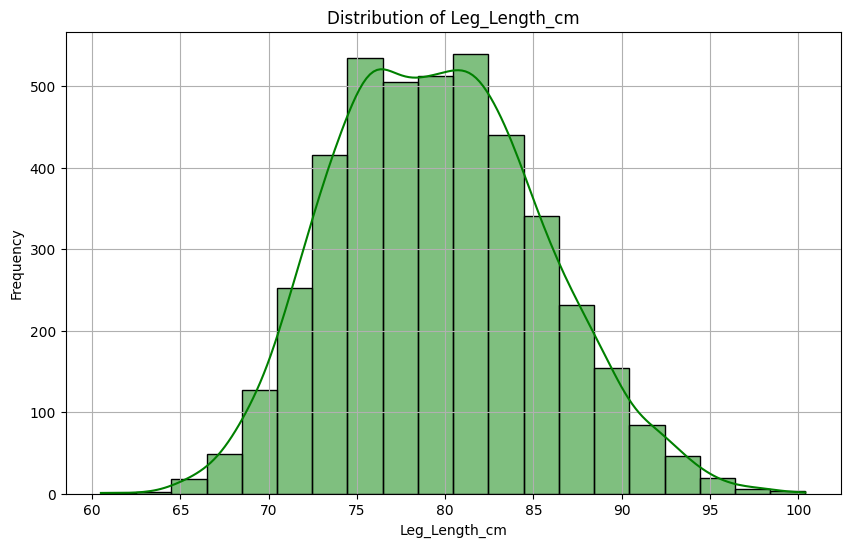

In [62]:
# observing the distribution to ascertain the most appropriate imputation method

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Leg_Length_cm'], bins=20, kde=True, color='green')
plt.title('Distribution of Leg_Length_cm')
plt.xlabel('Leg_Length_cm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [63]:
# Impute missing values for leg length using the median
leg_length_median = merged_df['Leg_Length_cm'].median()
merged_df['Leg_Length_cm'] = merged_df['Leg_Length_cm'].fillna(leg_length_median)

# Impute missing values for serum insulin measured in pmol/l using the median
serum_insulin_pmol_l_median = merged_df['Serum_Insulin_pmol_l_Avg'].median()
merged_df['Serum_Insulin_pmol_l_Avg'] = merged_df['Serum_Insulin_pmol_l_Avg'].fillna(serum_insulin_pmol_l_median)

serum_insulin_pmol_l_median = merged_df['First_Serum_Insulin_pmol_l'].median()
merged_df['First_Serum_Insulin_pmol_l'] = merged_df['First_Serum_Insulin_pmol_l'].fillna(serum_insulin_pmol_l_median)

# Convert missing values in serum insulin measured in uu/ml using the conversion formula
serum_insulin_uu_ml_missing = merged_df['Serum_Insulin_uu_ml_Avg'].isnull()
merged_df.loc[serum_insulin_uu_ml_missing, 'Serum_Insulin_uu_ml_Avg'] = merged_df.loc[serum_insulin_uu_ml_missing, 'Serum_Insulin_pmol_l_Avg'] / 6

serum_insulin_uu_ml_missing = merged_df['First_Serum_Insulin_uu_ml'].isnull()
merged_df.loc[serum_insulin_uu_ml_missing, 'First_Serum_Insulin_uu_ml'] = merged_df.loc[serum_insulin_uu_ml_missing, 'First_Serum_Insulin_pmol_l'] / 6

In [64]:
# ensuring that no missing values still persist

merged_df.isna().sum().sort_values(ascending=False)

SEQN                          0
Second_Plasma_Glucose         0
Standing_Height_cm            0
BMI                           0
Session_Time                  0
Serum_Insulin_pmol_l_Avg      0
Serum_Insulin_uu_ml_Avg       0
Plasma_Glucose_Avg_mmol_l     0
First_Serum_Insulin_pmol_l    0
First_Serum_Insulin_uu_ml     0
First_Plasma_Glucose          0
Sex                           0
White                         0
Black                         0
Mexican                       0
100_Cigarettes                0
Parental_Diabetes             0
Income_Greater_20             0
Grade_Greater_12              0
Age                           0
Leg_Length_cm                 0
dtype: int64

In [65]:
merged_df

,SEQN,Sex,Age,Grade_Greater_12,Income_Greater_20,Parental_Diabetes,100_Cigarettes,Mexican,Black,White,...,Second_Plasma_Glucose,First_Serum_Insulin_uu_ml,First_Serum_Insulin_pmol_l,Plasma_Glucose_Avg_mmol_l,Serum_Insulin_uu_ml_Avg,Serum_Insulin_pmol_l_Avg,Session_Time,BMI,Standing_Height_cm,Leg_Length_cm
0,9,1,48,1,1,1,1,0,0,1,...,7.882,10.80,64.80,7.0300,10.800,64.80,Morning,27.6,156.9,72.0
1,34,1,42,0,1,0,1,0,1,0,...,4.940,9.82,58.92,5.2150,9.820,58.92,Morning,22.6,159.0,77.1
2,51,0,44,0,0,0,1,1,0,0,...,8.493,40.00,240.00,6.6945,40.000,240.00,Morning,44.4,180.5,85.4
4,55,0,48,0,0,0,1,1,0,0,...,5.279,12.31,73.86,5.7455,12.310,73.86,Afternoon,37.5,172.6,80.8
6,72,0,60,0,0,1,1,0,1,0,...,11.441,9.07,54.42,9.4035,16.580,99.48,Morning,20.4,180.7,89.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5173,53558,1,55,1,1,0,0,0,0,1,...,4.979,6.98,41.88,4.9680,17.440,104.64,Morning,24.1,163.1,79.8
5174,53559,1,73,1,1,0,1,0,0,1,...,6.878,5.39,32.34,5.5845,36.070,216.42,Morning,24.2,151.7,72.8
5175,53569,1,42,0,1,1,0,0,0,0,...,8.182,5.26,31.56,6.4280,37.005,222.03,Afternoon,24.2,175.3,88.0
5177,53583,1,51,0,1,1,1,0,0,1,...,7.244,9.07,54.42,6.1340,37.300,223.80,Afternoon,22.2,155.9,71.4


In [66]:
# checking if both genders have balanced representation
# will be important since body fat percentage analysis stratifies on sex

merged_df['Sex'].value_counts()

Sex
1    2228
0    2093
Name: count, dtype: int64

In [67]:
merged_df.columns

Index(['SEQN', 'Sex', 'Age', 'Grade_Greater_12', 'Income_Greater_20',
       'Parental_Diabetes', '100_Cigarettes', 'Mexican', 'Black', 'White',
       'First_Plasma_Glucose', 'Second_Plasma_Glucose',
       'First_Serum_Insulin_uu_ml', 'First_Serum_Insulin_pmol_l',
       'Plasma_Glucose_Avg_mmol_l', 'Serum_Insulin_uu_ml_Avg',
       'Serum_Insulin_pmol_l_Avg', 'Session_Time', 'BMI', 'Standing_Height_cm',
       'Leg_Length_cm'],
      dtype='object')

In [68]:
def calculate_bmp(row) -> float:
    """
    This function uses a formula to obtain the body fat percentage from the BMI and Age of the subject
    """
    return 1.2 * row['BMI'] + 0.23 * row['Age'] - (10.8 * (1 - row['Sex'])) - 5.4

# for men BMP = (1.2 * BMI) + (0.23 * Age) - 16.2 (here Sex = 0)
# for women BMP = (1.2 * BMI) + (0.23 * Age) - 5.4 (here Sex = 1)

merged_df['Body_Mass_Percentage'] = merged_df.apply(calculate_bmp, axis=1)

In [69]:
# Calculate insulin resistance (IR) using the formula: IR = (fasting insulin * fasting glucose) / 22.5
merged_df['Insulin_Resistance'] = (merged_df['First_Serum_Insulin_uu_ml'] * merged_df['First_Plasma_Glucose']) / 22.5

In [70]:
# setting Glucose Tolerance classes (Normal, IGT, Diabetes)
# based on the description provided in the research paper

normal_condition_morning = (merged_df['Session_Time'] == 'Morning') & (merged_df['First_Plasma_Glucose'] < 7.8) & (merged_df['Second_Plasma_Glucose'] < 7.8)
normal_condition_afternoon_evening = (merged_df['Session_Time'] != 'Morning') & (merged_df['First_Plasma_Glucose'] < 7.8) & (merged_df['Second_Plasma_Glucose'] < 7.8)

igt_condition_morning = (merged_df['Session_Time'] == 'Morning') & (merged_df['First_Plasma_Glucose'] < 7.8) & (merged_df['Second_Plasma_Glucose'] >= 7.8) & (merged_df['Second_Plasma_Glucose'] <= 11.1)
igt_condition_afternoon_evening = (merged_df['Session_Time'] != 'Morning') & (merged_df['First_Plasma_Glucose'] < 7.8) & (merged_df['Second_Plasma_Glucose'] >= 7.8) & (merged_df['Second_Plasma_Glucose'] <= 13.9)

diabetes_condition_morning = (merged_df['Session_Time'] == 'Morning') & ((merged_df['First_Plasma_Glucose'] >= 7.8) | (merged_df['Second_Plasma_Glucose'] >= 11.1))
diabetes_condition_afternoon_evening = (merged_df['Session_Time'] != 'Morning') & ((merged_df['First_Plasma_Glucose'] >= 7.8) | (merged_df['Second_Plasma_Glucose'] >= 13.9))

merged_df['Glucose_Tolerance'] = 'Normal'  # Initialize with 'Normal'
merged_df.loc[normal_condition_morning | normal_condition_afternoon_evening, 'Glucose_Tolerance'] = 'Normal'
merged_df.loc[igt_condition_morning | igt_condition_afternoon_evening, 'Glucose_Tolerance'] = 'IGT'
merged_df.loc[diabetes_condition_morning | diabetes_condition_afternoon_evening, 'Glucose_Tolerance'] = 'Diabetes'

In [71]:
# dropping unrequired column

merged_df.drop(columns=['Session_Time'], inplace=True)

In [72]:
merged_df.columns

Index(['SEQN', 'Sex', 'Age', 'Grade_Greater_12', 'Income_Greater_20',
       'Parental_Diabetes', '100_Cigarettes', 'Mexican', 'Black', 'White',
       'First_Plasma_Glucose', 'Second_Plasma_Glucose',
       'First_Serum_Insulin_uu_ml', 'First_Serum_Insulin_pmol_l',
       'Plasma_Glucose_Avg_mmol_l', 'Serum_Insulin_uu_ml_Avg',
       'Serum_Insulin_pmol_l_Avg', 'BMI', 'Standing_Height_cm',
       'Leg_Length_cm', 'Body_Mass_Percentage', 'Insulin_Resistance',
       'Glucose_Tolerance'],
      dtype='object')

In [73]:
merged_df.head()

,SEQN,Sex,Age,Grade_Greater_12,Income_Greater_20,Parental_Diabetes,100_Cigarettes,Mexican,Black,White,...,First_Serum_Insulin_pmol_l,Plasma_Glucose_Avg_mmol_l,Serum_Insulin_uu_ml_Avg,Serum_Insulin_pmol_l_Avg,BMI,Standing_Height_cm,Leg_Length_cm,Body_Mass_Percentage,Insulin_Resistance,Glucose_Tolerance
0,9,1,48,1,1,1,1,0,0,1,...,64.80,7.0300,10.80,64.80,27.6,156.9,72.0,38.76,2.965440,IGT
1,34,1,42,0,1,0,1,0,1,0,...,58.92,5.2150,9.82,58.92,22.6,159.0,77.1,31.38,2.396080,Normal
2,51,0,44,0,0,0,1,1,0,0,...,240.00,6.6945,40.00,240.00,44.4,180.5,85.4,47.20,8.704000,IGT
4,55,0,48,0,0,0,1,1,0,0,...,73.86,5.7455,12.31,73.86,37.5,172.6,80.8,39.84,3.398654,Normal
6,72,0,60,0,0,1,1,0,1,0,...,54.42,9.4035,16.58,99.48,20.4,180.7,89.5,22.08,2.969316,Diabetes


In [74]:
# observing proportions of the glucose tolerance categories

merged_df['Glucose_Tolerance'].value_counts()

Glucose_Tolerance
Normal      2590
IGT         1375
Diabetes     356
Name: count, dtype: int64

# Modelling

In [75]:
merged_df.head()

,SEQN,Sex,Age,Grade_Greater_12,Income_Greater_20,Parental_Diabetes,100_Cigarettes,Mexican,Black,White,...,First_Serum_Insulin_pmol_l,Plasma_Glucose_Avg_mmol_l,Serum_Insulin_uu_ml_Avg,Serum_Insulin_pmol_l_Avg,BMI,Standing_Height_cm,Leg_Length_cm,Body_Mass_Percentage,Insulin_Resistance,Glucose_Tolerance
0,9,1,48,1,1,1,1,0,0,1,...,64.80,7.0300,10.80,64.80,27.6,156.9,72.0,38.76,2.965440,IGT
1,34,1,42,0,1,0,1,0,1,0,...,58.92,5.2150,9.82,58.92,22.6,159.0,77.1,31.38,2.396080,Normal
2,51,0,44,0,0,0,1,1,0,0,...,240.00,6.6945,40.00,240.00,44.4,180.5,85.4,47.20,8.704000,IGT
4,55,0,48,0,0,0,1,1,0,0,...,73.86,5.7455,12.31,73.86,37.5,172.6,80.8,39.84,3.398654,Normal
6,72,0,60,0,0,1,1,0,1,0,...,54.42,9.4035,16.58,99.48,20.4,180.7,89.5,22.08,2.969316,Diabetes


In [76]:
# obtaining the leg length to height ratio

merged_df['Leg_Length_to_Height_Ratio'] = (merged_df['Leg_Length_cm'] / merged_df['Standing_Height_cm']) * 100

In [77]:
# reinstating the race ethnicity as a categorical column
# will be used for getting the group wise z-scores as mentioned in the research

merged_df['Race_Ethnicity'] = 'Other'

# For rows where all three race/ethnicity columns are 0, set the Race_Ethnicity to 'Other'
mask_other = (merged_df['Mexican'] == 0) & (merged_df['Black'] == 0) & (merged_df['White'] == 0)
merged_df.loc[mask_other, 'Race_Ethnicity'] = 'Other'

# For rows where one of the race/ethnicity columns is 1, set the Race_Ethnicity accordingly
merged_df.loc[merged_df['Mexican'] == 1, 'Race_Ethnicity'] = 'Mexican'
merged_df.loc[merged_df['Black'] == 1, 'Race_Ethnicity'] = 'Black'
merged_df.loc[merged_df['White'] == 1, 'Race_Ethnicity'] = 'White'

In [78]:
# drop all rows with the other race-ethnicity

merged_df = merged_df[merged_df['Race_Ethnicity'] != 'Other']

In [79]:
# final shape of our data that will be used for modelling

merged_df.shape

(4148, 25)

In [80]:
# old approach - was not utilizing the mean and standard deviation values given in the paper

# columns_to_standardize = ['Standing_Height_cm', 'Leg_Length_cm', 'Leg_Length_to_Height_Ratio']

# # Define a function to standardize values within each group
# def standardize_within_group(group):
#     return (group - group.mean()) / group.std()

# # Standardize the specified columns within each group
# standardized_values = merged_df.groupby(['Race_Ethnicity', 'Sex'])[columns_to_standardize].transform(standardize_within_group)

# # Update the original DataFrame with the standardized values
# merged_df[columns_to_standardize] = standardized_values

In [81]:
# calculating z-scores using mean and std_dev values provided in the paper

mean_std_values = {
    'Standing_Height_cm': {
        0: {'White': (176.1, 6.7), 'Black': (175.4, 7.1), 'Mexican': (169.2, 6.3)},
        1: {'White': (162.0, 6.2), 'Black': (162.8, 6.2), 'Mexican': (156.0, 5.9)}
    },
    'Leg_Length_cm': {
        0: {'White': (83.7, 4.3), 'Black': (86.4, 4.7), 'Mexican': (79.9, 3.9)},
        1: {'White': (76.3, 4.0), 'Black': (78.9, 4.1), 'Mexican': (73.0, 3.7)}
    },
    'Leg_Length_to_Height_Ratio': {
        0: {'White': (47.5, 1.2), 'Black': (49.2, 1.4), 'Mexican': (47.2, 1.2)},
        1: {'White': (47.1, 1.3), 'Black': (48.5, 1.4), 'Mexican': (46.8, 1.3)}
    }
}

columns_to_standardize = ['Standing_Height_cm', 'Leg_Length_cm', 'Leg_Length_to_Height_Ratio']

for col in columns_to_standardize:
    for sex in [0, 1]:
        for ethnicity in ['White', 'Black', 'Mexican']:
            mean_val, std_val = mean_std_values[col][sex][ethnicity]
            mask = (merged_df['Sex'] == sex) & (merged_df['Race_Ethnicity'] == ethnicity)
            merged_df.loc[mask, col] = (merged_df.loc[mask, col] - mean_val) / std_val

In [82]:
merged_df.columns

Index(['SEQN', 'Sex', 'Age', 'Grade_Greater_12', 'Income_Greater_20',
       'Parental_Diabetes', '100_Cigarettes', 'Mexican', 'Black', 'White',
       'First_Plasma_Glucose', 'Second_Plasma_Glucose',
       'First_Serum_Insulin_uu_ml', 'First_Serum_Insulin_pmol_l',
       'Plasma_Glucose_Avg_mmol_l', 'Serum_Insulin_uu_ml_Avg',
       'Serum_Insulin_pmol_l_Avg', 'BMI', 'Standing_Height_cm',
       'Leg_Length_cm', 'Body_Mass_Percentage', 'Insulin_Resistance',
       'Glucose_Tolerance', 'Leg_Length_to_Height_Ratio', 'Race_Ethnicity'],
      dtype='object')

In [83]:
# Standardize 'Age'
merged_df.loc[:, 'Age'] = ((merged_df['Age'] - merged_df['Age'].mean()) / merged_df['Age'].std()).astype(float)

## For Percent Body Fat

In [84]:
# setting up functions that will fit the OLS models and return the required information

def bmp_model1(data, main_predictor, sex):
    # Filter data by sex
    sex_data = data[data['Sex'] == sex]
    
    # Define predictors for Model 1
    predictors = [main_predictor, 'Age']  # Adjust as per your requirements
    
    # Add constant term to the predictors
    X = sm.add_constant(sex_data[predictors])
    
    # Define target variable
    y = sex_data['Body_Mass_Percentage']
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    beta = model.params[main_predictor]
    ci_low, ci_high = model.conf_int().loc[main_predictor][0], model.conf_int().loc[main_predictor][1]
    p_value = model.pvalues[main_predictor]
    
    results = {
#         'cur_model' : model,
        'beta' : beta,
        'ci_low' : ci_low,
        'ci_high' : ci_high,
        'p_value' : p_value
    }
    
    return results

def bmp_model2(data, main_predictor, sex):
    # Filter data by sex
    sex_data = data[data['Sex'] == sex]
    
    # Define predictors for Model 2
    predictors = [main_predictor, 'Age', 'Parental_Diabetes', 'Income_Greater_20', 
                  '100_Cigarettes', 'Grade_Greater_12'] 
    
    # Add constant term to the predictors
    X = sm.add_constant(sex_data[predictors])
    
    # Define target variable
    y = sex_data['Body_Mass_Percentage']
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    beta = model.params[main_predictor]
    ci_low, ci_high = model.conf_int().loc[main_predictor][0], model.conf_int().loc[main_predictor][1]
    p_value = model.pvalues[main_predictor]
    
    results = {
#         'cur_model' : model,
        'beta' : beta,
        'ci_low' : ci_low,
        'ci_high' : ci_high,
        'p_value' : p_value
    }
    
    return results

In [85]:
# running all variants needed to replicate results for Table 3 Body Fat Percentage

main_predictors = ['Standing_Height_cm', 'Leg_Length_cm', 'Leg_Length_to_Height_Ratio']
models = [bmp_model1, bmp_model2]
sex_values = [0, 1]

bmp_results = {}

for main_predictor in main_predictors:
    bmp_results[main_predictor] = {}
    for model in models:
        bmp_results[main_predictor][model.__name__] = {}
        for sex_value in sex_values:
            cur_results = model(merged_df, main_predictor, sex_value)
            bmp_results[main_predictor][model.__name__][sex_value] = cur_results

In [86]:
# reorganizing the results in a dataframe

flatten_results = []

for main_predictor, models_data in bmp_results.items():
    for model_name, sex_data in models_data.items():
        for sex_value, results in sex_data.items():
            flatten_results.append({
                'Main_Predictor': main_predictor,
                'Model': model_name,
                'Sex': sex_value,
                'Beta': results['beta'],
                'CI_Low': results['ci_low'],
                'CI_High': results['ci_high'],
                'P_Value': results['p_value']
            })

# Convert to DataFrame
bmp_results_df = pd.DataFrame(flatten_results)

# reformatting values to match the manner required 
# (1SD lower values instead of default 1SD higher values)
bmp_results_df[['Beta', 'CI_Low', 'CI_High']] *= -1
bmp_results_df[['CI_Low', 'CI_High']] = bmp_results_df[['CI_High', 'CI_Low']]

In [87]:
bmp_results_df['Sex'] = bmp_results_df['Sex'].map({0: 'Men', 1: 'Women'})

# Format numerical columns to two decimal places using map
bmp_results_df['Beta'] = bmp_results_df['Beta'].map('{:.2f}'.format)
bmp_results_df['CI_Low'] = bmp_results_df['CI_Low'].map('{:.2f}'.format)
bmp_results_df['CI_High'] = bmp_results_df['CI_High'].map('{:.2f}'.format)

# Replace p-values based on significance using map
bmp_results_df['P_Value'] = bmp_results_df['P_Value'].map(lambda x: 'significant' if x < 0.05 else 'insignificant')

In [88]:
bmp_results_df.drop(columns=['P_Value'], inplace=True)
bmp_results_df.set_index(['Main_Predictor', 'Model', 'Sex'], inplace=True)

In [89]:
bmp_results_df

Beta CI_Low CI_High
Main_Predictor             Model      Sex                        
Standing_Height_cm         bmp_model1 Men    -0.18  -0.42    0.07
                                      Women   0.60   0.27    0.93
                           bmp_model2 Men    -0.17  -0.41    0.08
                                      Women   0.43   0.10    0.76
Leg_Length_cm              bmp_model1 Men     0.43   0.19    0.67
                                      Women   1.22   0.90    1.54
                           bmp_model2 Men     0.43   0.20    0.67
                                      Women   1.10   0.78    1.41
Leg_Length_to_Height_Ratio bmp_model1 Men     1.07   0.84    1.30
                                      Women   1.51   1.19    1.83
                           bmp_model2 Men     1.05   0.83    1.28
                                      Women   1.49   1.18    1.81

Section Summary: <br>
1. The main findings of the paper revealed significant associations between sex and anthropometric measurements in predicting percent body fat. Specifically, women with shorter height, shorter leg length, and lower leg length-to-height ratio exhibited significantly higher percent body fat, even after adjusting for potential confounders. In contrast, men showed a similar but weaker pattern of associations.
2. Our analysis successfully replicated these main findings, demonstrating consistent trends between anthropometric measurements and body mass percentage, including the relative comparisons of association strengths between Men and Women. Through thorough examination and stratification by sex, we were able to confirm the paper's conclusions regarding the relationships between various body measurements and percent body fat stratified on gender.
3. It is noteworthy that the majority of our findings closely matched those reported in the paper. However, slight differences were observed in a few values, particularly in relation to predicting body mass percentage using the Leg Length to Height ratio. Despite these differences, it's important to emphasize that they are small and statistically insignificant when considering the scale of the outcome variable.
4. Several factors may account for these minor discrepancies. Challenges in parsing columns with a large number of missing values, variations in sample composition, and the use of identical weightings as the original study could have contributed. Nevertheless, it's crucial to underscore that these differences do not detract from the overall robustness of our analysis, which confirms the paper's conclusions regarding the associations between anthropometric measurements and body mass percentage.

## For HOMA-IR

In [90]:
# obtaining the log of HOMA-IR values as per the paper

merged_df.loc[:, 'Log_Insulin_Resistance'] = np.log(merged_df['Insulin_Resistance'])

In [91]:
# scaling body mass percentage to use it as a feature in model 3

scaler = StandardScaler()
merged_df.loc[:, 'Std_Body_Mass_Percentage'] = scaler.fit_transform(merged_df[['Body_Mass_Percentage']])

In [92]:
# setting up the function which fits the OLS model for HOMA-IR and returns required information

def ir_model(data, main_predictor, other_predictors):
    # Define predictors for the model
    
    predictors = [main_predictor]
    predictors.extend(other_predictors)
    
    # Add constant term to the predictors
    X = sm.add_constant(data[predictors])
    
    # Define target variable
    y = data['Log_Insulin_Resistance']
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    beta = -1 * model.params[main_predictor]
    ci_low, ci_high = -1 * model.conf_int().loc[main_predictor][0], -1 * model.conf_int().loc[main_predictor][1]
    p_value = model.pvalues[main_predictor]
    significance = "significant" if p_value < 0.05 else "insignificant"
    
    ci_low, ci_high = ci_high, ci_low
    
    beta = round(beta, 2) + 1
    ci_low = round(ci_low, 2) + 1
    ci_high = round(ci_high, 2) + 1
    
    results = {
        'multiplicative_factor' : beta,
        'ci_low' : ci_low,
        'ci_high' : ci_high,
        'p_value' : significance
    }
    
    return results

In [93]:
# defining all sets of other confounders to be used in Model 1, Model 2 and Model 3

model_other_predictors = [
    ['Age'],
    ['Age', 'Parental_Diabetes', 'Income_Greater_20', '100_Cigarettes', 'Grade_Greater_12'],
    ['Age', 'Parental_Diabetes', 'Income_Greater_20', '100_Cigarettes', 'Grade_Greater_12', 'Std_Body_Mass_Percentage']
]

In [94]:
# running all variants to replicate the results in Table 3 for HOMA-IR

main_predictors = ['Standing_Height_cm', 'Leg_Length_cm', 'Leg_Length_to_Height_Ratio']

ir_results = {}

for main_predictor in main_predictors:
    ir_results[main_predictor] = {}
    for i in range(len(model_other_predictors)):
        cur_results = ir_model(merged_df, main_predictor, model_other_predictors[i])
        model_name = 'Model_' + str(i+1)
        ir_results[main_predictor][model_name] = cur_results

In [95]:
# rearranging data in a data frame

flatten_results = []

for main_predictor, models_data in ir_results.items():
    for model_name, results in models_data.items():
        flatten_results.append({
            'Main_Predictor': main_predictor,
            'Model': model_name,
            'Multiplicative_Factor': results['multiplicative_factor'],
            'CI_Low': results['ci_low'],
            'CI_High': results['ci_high'],
            'P_Value': results['p_value']
        })

# Convert to DataFrame
ir_results_df = pd.DataFrame(flatten_results)

In [96]:
ir_results_df.drop(columns=['P_Value'], inplace=True)
ir_results_df.set_index(['Main_Predictor', 'Model'], inplace=True)

In [97]:
ir_results_df

Multiplicative_Factor  CI_Low  CI_High
Main_Predictor             Model                                          
Standing_Height_cm         Model_1                   0.98    0.96     1.00
                           Model_2                   0.98    0.96     1.00
                           Model_3                   0.98    0.96     0.99
Leg_Length_cm              Model_1                   1.03    1.01     1.05
                           Model_2                   1.03    1.01     1.04
                           Model_3                   1.01    0.99     1.02
Leg_Length_to_Height_Ratio Model_1                   1.08    1.06     1.10
                           Model_2                   1.08    1.06     1.10
                           Model_3                   1.04    1.03     1.06

Section Summary: <br>
1. The main findings of the paper revealed significant associations between the anthropometric measurement of Leg Length to Height ratio and greater HOMA-IR values with the remaining two measurements, Height and Leg Length, not displaying any consistent associations.
2. Our analysis successfully replicated these main findings, including achieveing extremely similar multiplicative factor values as reported in Table 3 of the paper. Our results were able to display the high association between Leg Length to Height ratio and HOMA-IR, with the lower values of the former being directly linked to higher values of the latter. The attenuation mentioned in the paper's results was also visible in our results with the multiplicative factor dropping from 1.08 to 1.04 as we included body fat percentage as a confounder in Model 3.
3. It is noteworthy to mention that not only do our multiplicative factor values pretty much match those of the paper's but the confidence intervals also display a significant overlap further confirming our successful replication of the analysis performed by the authors.

## For Glucose Tolerance

In [98]:
merged_df.reset_index(drop=True, inplace=True)

In [99]:
# changing category names
# MNLogit uses the first category alphanumerically as reference
# we need the reference to be Normal and therefore this renaming is done

category_mapping = {'Normal': 'cat_1', 'IGT': 'cat_2', 'Diabetes': 'cat_3'}
merged_df.loc[:, 'Glucose_Tolerance'] = merged_df['Glucose_Tolerance'].replace(category_mapping)

In [100]:
merged_df['Glucose_Tolerance']

0       cat_2
1       cat_1
2       cat_2
3       cat_1
4       cat_3
        ...  
4143    cat_1
4144    cat_1
4145    cat_1
4146    cat_1
4147    cat_1
Name: Glucose_Tolerance, Length: 4148, dtype: object

In [101]:
# observing proportions of glucose tolerance classes within our data

merged_df['Glucose_Tolerance'].value_counts()

Glucose_Tolerance
cat_1    2489
cat_2    1317
cat_3     342
Name: count, dtype: int64

In [102]:
# setting up the function which fits the multinomial logistic regression model
# and returns the required information

def gt_model(data, main_predictor, other_predictors):
    y = data['Glucose_Tolerance']
    
    predictors = [main_predictor]
    predictors.extend(other_predictors)
    
    X = data[predictors]
    X = sm.add_constant(X)
    
    model = sm.MNLogit(y, X)
    model_result = model.fit()
    
    cat2_beta, cat3_beta = list(model_result.params.loc[main_predictor])
    cat2_beta = round(np.exp(-1*cat2_beta), 2)
    cat3_beta = round(np.exp(-1*cat3_beta), 2)
    
    cat2_p, cat3_p = list(model_result.pvalues.loc[main_predictor])
    cat2_p = 'significant' if cat2_p < 0.05 else 'insignificant'
    cat3_p = 'significant' if cat3_p < 0.05 else 'insignificant'
    
    
    cat2_low, cat2_high = model_result.conf_int().loc[('cat_2', main_predictor), :]
    cat2_low = round(np.exp(-1*cat2_low), 2)
    cat2_high = round(np.exp(-1*cat2_high), 2)
    cat2_low, cat2_high = cat2_high, cat2_low
    
    cat3_low, cat3_high = model_result.conf_int().loc[('cat_3', main_predictor), :]
    cat3_low = round(np.exp(-1*cat3_low), 2)
    cat3_high = round(np.exp(-1*cat3_high), 2)
    cat3_low, cat3_high = cat3_high, cat3_low
    
    result = {
        'IGT': {
            'prevalence_ratio': cat2_beta,
            'ci_low': cat2_low,
            'ci_high': cat2_high,
            'significance': cat2_p,
        },
        'Diabetes': {
            'prevalence_ratio': cat3_beta,
            'ci_low': cat3_low,
            'ci_high': cat3_high,
            'significance': cat3_p,
        }
    }
    
    return result

In [103]:
# running all variants to replicate the results in Table 3 for Glucose Tolerance

main_predictors = ['Standing_Height_cm', 'Leg_Length_cm', 'Leg_Length_to_Height_Ratio']

gt_results = {}

for main_predictor in main_predictors:
    gt_results[main_predictor] = {}
    for i in range(len(model_other_predictors)):
        cur_results = gt_model(merged_df, main_predictor, model_other_predictors[i])
        model_name = "Model_" + str(i+1)
        gt_results[main_predictor][model_name] = cur_results

Optimization terminated successfully.
         Current function value: 0.844936
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.836094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.826466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.844480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.835662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.826466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.844979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.835839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.826846
         Iterations 7


In [104]:
# rearranging data into a data frame

data = []

# Iterate over the gt_results dictionary
for predictor, models in gt_results.items():
    for model, categories in models.items():
        for category, results in categories.items():
            data.append([predictor, model, category, results['prevalence_ratio'], results['ci_low'], results['ci_high'], results['significance']])

# Create DataFrame
gt_results_df = pd.DataFrame(data, columns=['Main_Predictor', 'Model', 'Category', 'Prevalence_Ratio', 'CI_Low', 'CI_High', 'Significance'])

In [105]:
gt_results_df.drop(columns=['Significance'], inplace=True)
gt_results_df.set_index(['Main_Predictor', 'Model'], inplace=True)

In [106]:
gt_results_df

Category  Prevalence_Ratio  CI_Low  \
Main_Predictor             Model                                         
Standing_Height_cm         Model_1       IGT              1.12    1.04   
                           Model_1  Diabetes              1.09    0.97   
                           Model_2       IGT              1.10    1.02   
                           Model_2  Diabetes              1.06    0.94   
                           Model_3       IGT              1.09    1.02   
                           Model_3  Diabetes              1.06    0.94   
Leg_Length_cm              Model_1       IGT              1.12    1.05   
                           Model_1  Diabetes              1.15    1.02   
                           Model_2       IGT              1.11    1.03   
                           Model_2  Diabetes              1.13    1.00   
                           Model_3       IGT              1.08    1.01   
                           Model_3  Diabetes              1.10    0.98   
Leg_Length_to_Height_Ratio Model_1       IGT              1.08    1.01   
                           Model_1  Diabetes              1.17    1.04   
                           Model_2       IGT              1.07    1.00   
                           Model_2  Diabetes              1.16    1.03   
                           Model_3       IGT              1.03    0.96   
                           Model_3  Diabetes              1.11    0.98   

                                    CI_High  
Main_Predictor             Model             
Standing_Height_cm         Model_1     1.20  
                           Model_1     1.23  
                           Model_2     1.18  
                           Model_2     1.20  
                           Model_3     1.18  
                           Model_3     1.20  
Leg_Length_cm              Model_1     1.20  
                           Model_1     1.29  
                           Model_2     1.18  
                           Model_2     1.27  
                           Model_3     1.16  
                           Model_3     1.24  
Leg_Length_to_Height_Ratio Model_1     1.15  
                           Model_1     1.31  
                           Model_2     1.15  
                           Model_2     1.30  
                           Model_3     1.11  
                           Model_3     1.24

Section Summary: <br>
1. The main findings in the paper were that shorter height, shorted leg length, and lower leg length or height ratio were associated with higher prevalence of diabetes. Additionally similar patterns were observed with respect to IGT as well but on a slightly weaker level. The paper also mentions that many of the scores obtained were not significant in a two-tailed test and therefore it may be difficult to get exact values.
2. Our analysis successfully replicated these main findings, demonstrating consistent trends in associations for both Diabetes and IGT. We observe that in all situations / models, the prevalence ratios came out to be above 1. This confirms the findings which mention that lower values of these anthropometric measurements leads to higher risk of Diabetes and Impaired Glucose Tolerance.
3. It is important to note that while the exact values may be slightly off from the values presented in the paper, one potential reason for this, as mentioned above, is that most of these values have been deemed to be statistically insignificant. Another reason may be the imbalance in the classes where the number of subjects who are grouped as having Diabetes are significantly lower than that of the Normal and IGT groups. Inspite of this, we see that due to the scale, these differences do not hold any statistical significance. To further ensure the accurate reproducibility we are better placed to observe the comparitive trends and the closeness in the confidence intervals. We can see that in both these metrics, our analysis prove to be quite successful and sufficient. Therefore, we can confidently say that the results with respect to Glucose Tolerance have been successfully confirmed and replicated in our analysis.